In [1]:
# for folders one level below the heirarchy
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)


from GWS_Summer2024.slmfunctions.dependencies import *
from GWS_Summer2024.slmfunctions.settings import *
from GWS_Summer2024.slmfunctions.simulation import *
from GWS_Summer2024.slmfunctions.imageprocessing import *
from GWS_Summer2024.slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


In [130]:
import cupy as cp
import numpy as np

# Number of points in awgspace
numcycles = 30 # Number of cycles in the waveform
aodaperture = 2e-3 # Aperture size of the AOD
soundvelocity = 5.9e3   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
totalsimulationtime = numcycles * cycletime   # Total simulation time
wavelength = 650* 10**(-9) # Wavelength of the light
focallength = 250 * 10**(-3) # mm

print("Total simulation time in nanoseconds: ", totalsimulationtime*1e9)
print("Cycletime in nanoseconds: ", cycletime * 1e9)

aodresolution = 500
aodpixelpitch = aodaperture / aodresolution
aodfourierpitch = wavelength * focallength / (aodaperture)
print("Aod pixel pitch in microns: ", aodpixelpitch*1e6)
print("Fourier space spacing in microns: ", aodfourierpitch*10**6)
simulationspace = numcycles  * aodresolution


awgspace = cp.linspace(0, 10, simulationspace)  # Discretized space for the waveform

Total simulation time in nanoseconds:  10169.491525423728
Cycletime in nanoseconds:  338.9830508474576
Aod pixel pitch in microns:  4.0
Fourier space spacing in microns:  81.25


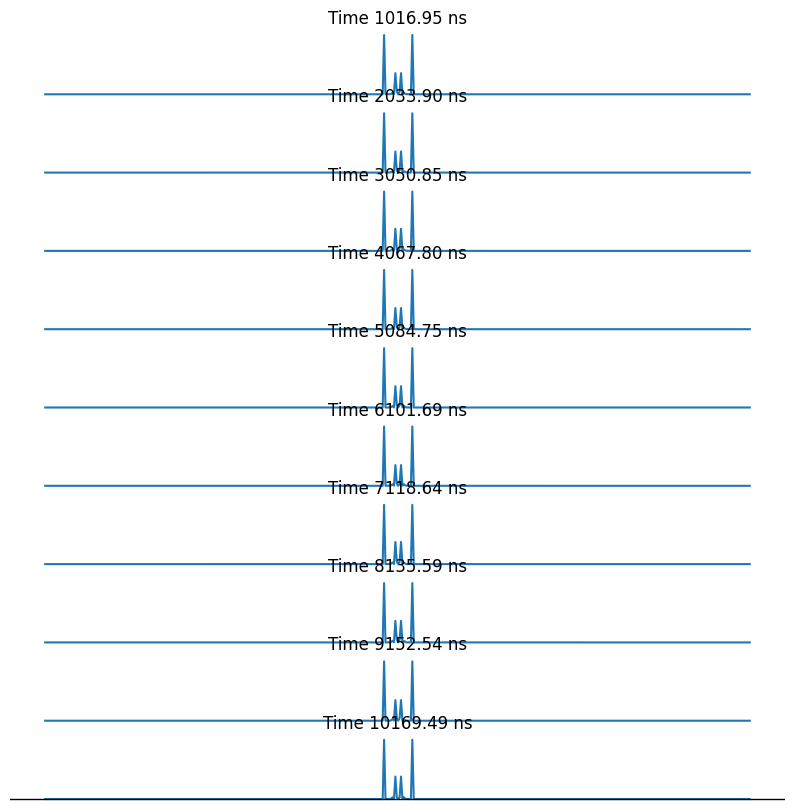

In [107]:
# Maximum number of terms for Fourier series and Legendre polynomials

# Precompute Legendre polynomials using NumPy
# max_legendre_terms = 55
# legendre_polynomials_np = np.polynomial.legendre.legval(np.linspace(0, 1, X), np.eye(max_legendre_terms).T)
# legendre_polynomials = cp.array(legendre_polynomials_np)

# fx, fy correspond to fourier space pixels, while rx, ry correspond to real space pixels

def calculateAWGwaveform(coefficients, phases, linspace):
    """
    Calculate and sum the Fourier series using amplitude-phase form.
    
    Parameters:
    coefficients (cp.ndarray): Array of Fourier coefficients.
    phases (cp.ndarray): Array of initial phases.
    x (cp.ndarray): Linear space array.
    
    Returns:
    cp.ndarray: Array of the Fourier series values.
    """
    
    # Ensure inputs are CuPy arrays
    coefficients = cp.asarray(coefficients)
    phases = cp.asarray(phases)    
    # Initialize the Fourier series sum
    fourier_series = cp.zeros_like(linspace, dtype=cp.float32)
    
    # Calculate the Fourier series sum
    for n, (A_n, phi_n) in enumerate(zip(coefficients, phases), start=1):
        fourier_series += A_n * cp.cos(2 * cp.pi * n *linspace + phi_n)
    
    return fourier_series

def snapshot(waveform, time, aodpixelpitch, aodresolution, numcycles, soundvelocity):
    """
    Take a snapshot of the waveform at a given time.
    
    Parameters:
    waveform (cp.ndarray): The waveform to sample.
    time (float): The time at which to sample the waveform.
    aodpixelpitch (float): The pixel pitch of the AOD.
    aodresolution (int): The resolution of the AOD.
    numcycles (int): The number of cycles in the waveform.
    soundvelocity (float): The sound velocity in the medium.
    
    Returns:
    cp.ndarray: The sampled waveform.
    """
    # Calculate the position of the AOD at the given time
    position = soundvelocity * time
    # Calculate the index of the AOD at the given time
    index = int(cp.round(position / aodpixelpitch))
    # Calculate the waveform at the given time
    sampledwaveform = waveform[index:index+aodresolution]
    
    return sampledwaveform

def fouriersimulation(inputarray):
    """
    Simulate the Fourier transform of a waveform.
    
    Parameters:
    inputarray (cp.ndarray): The input waveform.
    
    Returns:
    cp.ndarray: The Fourier transform of the input waveform.
    """
    # Perform the Fourier transform
    outputarray = cpfft.fftshift(cpfft.fft(cpfft.fftshift(inputarray), norm="ortho"))
    fourierintensity = cp.square (cp.abs(outputarray))
    return fourierintensity

def takefouriersnapshots(waveform, timestoshow, aodpixelpitch, aodresolution, numcycles, soundvelocity):
    """
    Take snapshots of the Fourier transform of a waveform at given times.
    
    Parameters:
    waveform (cp.ndarray): The waveform to sample.
    timestoshow (cp.ndarray): The times at which to sample the waveform.
    aodpixelpitch (float): The pixel pitch of the AOD.
    aodresolution (int): The resolution of the AOD.
    numcycles (int): The number of cycles in the waveform.
    soundvelocity (float): The sound velocity in the medium.
    
    Returns:
    cp.ndarray: The sampled waveforms.
    """
    # Initialize the snapshots array
    snapshots = cp.zeros((len(timestoshow), aodresolution), dtype=cp.float32)
    
    # Take snapshots of the waveform at the given times
    for i, time in enumerate(timestoshow):    
        snapshots[i] = fouriersimulation(snapshot(waveform, time, aodpixelpitch, aodresolution, numcycles, soundvelocity))

    return snapshots

def plotsnapshots(snapshotarray):
    """
    Plot snapshots of the Fourier transform of a waveform.
    
    Parameters:
    snapshotarray (cp.ndarray): The snapshots to plot.
    """
    # Create a figure and axis
    fig, ax = plt.subplots(len(snapshotarray), 1, figsize=(10, 10))
    
    # Plot each snapshot
    for i, snapshot in enumerate(snapshotarray):
        ax[i].plot(cp.asnumpy(snapshot))
        ax[i].set_title(f"Time {(i+1) * totalsimulationtime / len(snapshotarray) * 1e9:.2f} ns")
        ax[i].axis("off")
    
    # Add global x-axis ruler
    ax[-1].axhline(0, color='black', linewidth=1)
    ax[-1].set_xlabel('Sample Index')
    
    # Set x-axis tickers
    ax[-1].set_xticks(np.arange(0, aodresolution, 100))
    
    plt.show()

        

# Example coefficients (for demonstration purposes, normally these would be optimized)
fouriercoefficients = cp.array([0,0,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5])
phases = cp.random.rand(len(fouriercoefficients)) * 2 * cp.pi
# Calculate the waveform
waveform = calculateAWGwaveform(fouriercoefficients / cp.linalg.norm(fouriercoefficients), phases, awgspace)
# Convert the waveform back to numpy for visualization or other processing
waveform_numpy = cp.asnumpy(waveform)
testsnapshot= snapshot(waveform, totalsimulationtime - cycletime, aodpixelpitch, aodresolution, numcycles, soundvelocity)
testfourier = fouriersimulation(waveform)
snapshots = takefouriersnapshots(waveform, cp.array(cp.linspace(0, totalsimulationtime - cycletime, 10)), aodpixelpitch, aodresolution, numcycles, soundvelocity)
plotsnapshots(snapshots)

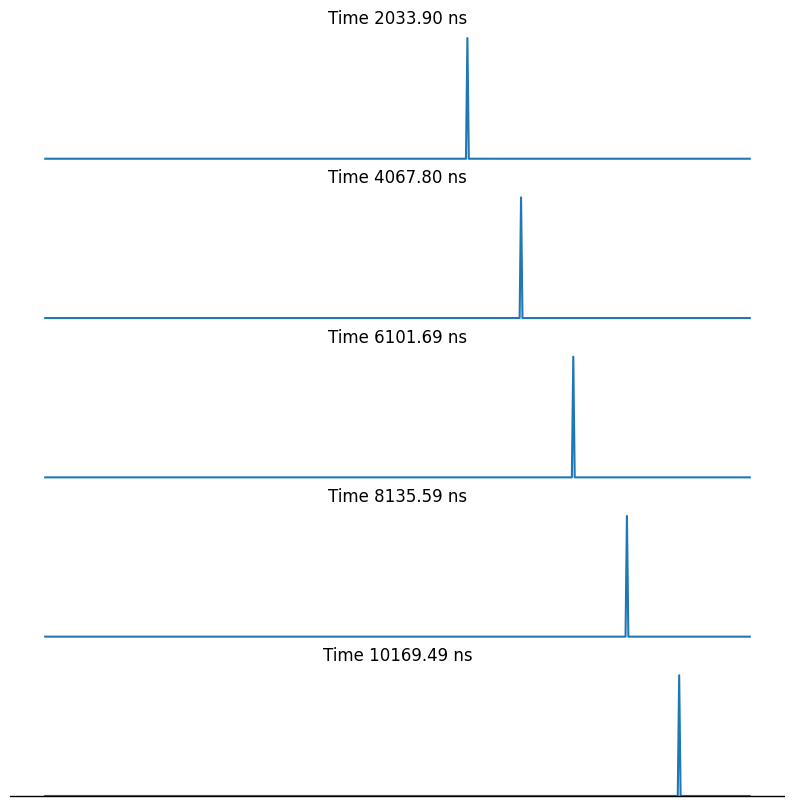

In [134]:

def generate_gaussian_arrays(start_fx, end_fx, aodresolution, numtargets, sigma):
    # Calculate the center positions for the Gaussian functions
    centers = cp.linspace(start_fx, end_fx, numtargets)
    
    # Create the x values for the arrays
    x = cp.linspace(0, aodresolution, aodresolution)
    
    # Generate the Gaussian arrays
    gaussian_arrays = []
    for center in centers:
        gaussian = cp.exp(-0.5 * ((x - center) / sigma) ** 2)
        gaussian_arrays.append(gaussian)
    
    return cp.array(gaussian_arrays)

# Example usage
start_fx = 300
end_fx = 450
aodresolution = 500
numtargets = 5
sigma = 0.1

gaussian_arrays = generate_gaussian_arrays(start_fx, end_fx, aodresolution, numtargets, sigma)
plotsnapshots(gaussian_arrays)

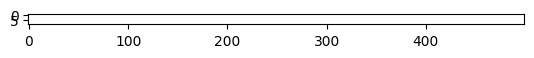

In [96]:
plt.imshow(snapshots.get())

In [72]:
cp.shape(testsnapshot)

(500,)

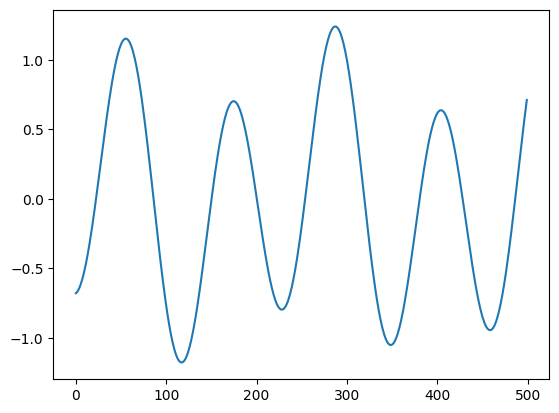

In [73]:
plt.plot(testsnapshot.get())